In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from tensorflow.keras.utils import to_categorical
from scipy.stats import linregress
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base

# NOT UPLOADED TO GITHUB
from config import PASSWORD, USERNAME, DATABASE_NAME, ENDPOINT

In [6]:
engine = create_engine(f'postgresql+psycopg2://{USERNAME}:{PASSWORD}@{ENDPOINT}/{DATABASE_NAME}')
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['listings', 'calendar', 'reviews', 'listings_clean']

In [7]:
#Assigning tables to variables
listings = Base.classes.listings
calendar = Base.classes.calendar
reviews = Base.classes.reviews

In [8]:
session = Session(engine)
listings_id = session.query(listings.id)

sql_query_listings = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM listings_clean
                               ''', engine)




In [9]:
df_list = pd.DataFrame(sql_query_listings, columns = sql_query_listings.keys())
df_list = df_list.rename(columns={'id': 'listing_id'})
df_list.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0
1,953595,Seattle,WA,98119,47.639123,-122.365666,4,1.0,1.0,1.0,150.0,96.0
2,3308979,Seattle,WA,98119,47.629724,-122.369483,11,4.5,5.0,7.0,975.0,97.0
3,278830,Seattle,WA,98119,47.632918,-122.372471,6,2.0,3.0,3.0,450.0,92.0
4,5956968,Seattle,WA,98119,47.630525,-122.366174,2,1.0,1.0,1.0,120.0,95.0


In [10]:
sql_query_calendar = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM calendar_clean
                               ''', engine)

df_cal = pd.DataFrame(sql_query_calendar, columns = sql_query_calendar.keys())
df_cal.head()

,listing_id,date,available,price
0,241032,1,t,85.0
1,241032,1,t,85.0
2,241032,1,t,85.0
3,241032,1,t,85.0
4,241032,1,t,85.0


In [11]:
df_cal_g = df_cal.groupby(['listing_id','date']).mean()
df_cal_g

price
listing_id date       
3335       1     120.0
           2     120.0
           3     120.0
           4     120.0
           5     120.0
...                ...
10340165   8      43.0
           9      43.0
           10     43.0
           11     43.0
           12     43.0

[33939 rows x 1 columns]

In [12]:
df_cal_g = df_cal_g.reset_index(level=['date'])
df_cal_g.head()

,date,price
listing_id,,
3335,1,120.0
3335,2,120.0
3335,3,120.0
3335,4,120.0
3335,5,120.0


In [13]:
df = df_list.merge(df_cal_g, how='inner', on='listing_id')
df.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price_x,review_scores_rating,date,price_y
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,1,85.0
1,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,2,85.0
2,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,3,85.0
3,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,4,85.0
4,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,5,85.0


In [14]:
df.rename(columns={"price_y":'price','date':'month'}, inplace=True)
df.head()

,listing_id,city,state,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price_x,review_scores_rating,month,price
0,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,1,85.0
1,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,2,85.0
2,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,3,85.0
3,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,4,85.0
4,241032,Seattle,WA,98119,47.636289,-122.371025,4,1.0,1.0,1.0,85.0,95.0,5,85.0


In [15]:
df.drop(columns=['state','listing_id','price_x'], inplace=True)

In [16]:
df.head()

,city,zipcode,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_rating,month,price
0,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,1,85.0
1,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,2,85.0
2,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,3,85.0
3,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,4,85.0
4,Seattle,98119,47.636289,-122.371025,4,1.0,1.0,1.0,95.0,5,85.0


In [17]:
df.price.min()

20.0

In [18]:
df_alt = df.drop(columns=['price'])

In [24]:
import pickle

pickle.dump(df_alt, open('df.sav','wb'))

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 2.6000e+01, 0.0000e+00,
        8.0000e+00, 8.0000e+00, 1.2300e+02, 1.8200e+02, 2.3200e+02,
        1.1420e+03, 1.7220e+03, 6.9350e+03, 1.8073e+04]),
 array([ 20.        ,  25.71428571,  31.42857143,  37.14285714,
         42.85714286,  48.57142857,  54.28571429,  60.        ,
         65.71428571,  71.42857143,  77.14285714,  82.85714286,
         88.57142857,  94.28571429, 100.        ]),
 <BarContainer object of 14 artists>)

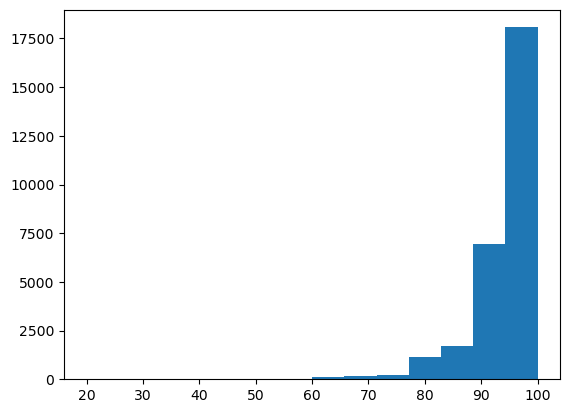

In [25]:
plt.hist(df['review_scores_rating'], bins=14)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.6000e+01, 0.0000e+00, 1.2000e+01, 1.0300e+02,
        1.8300e+02, 3.1400e+02, 3.2470e+03, 2.4566e+04]),
 array([1.30103   , 1.35095642, 1.40088285, 1.45080928, 1.50073571,
        1.55066214, 1.60058857, 1.650515  , 1.70044143, 1.75036786,
        1.80029428, 1.85022071, 1.90014714, 1.95007357, 2.        ]),
 <BarContainer object of 14 artists>)

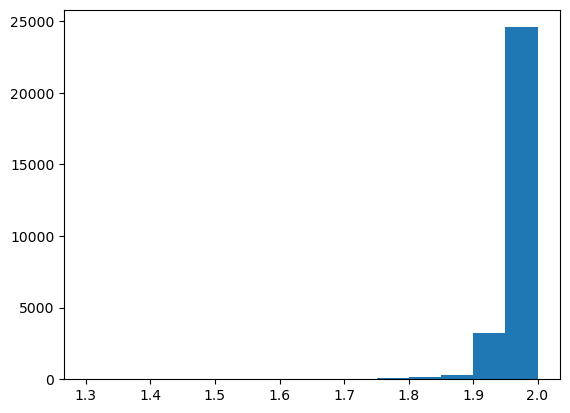

In [26]:
plt.hist(df['review_scores_rating'].apply(np.log10), bins=14)

In [27]:
# df['review_scores_rating'] = df['review_scores_rating'].apply(np.log10)

(array([21084.,  4754.,  2381.,   167.,    67.]),
 array([0. , 1.4, 2.8, 4.2, 5.6, 7. ]),
 <BarContainer object of 5 artists>)

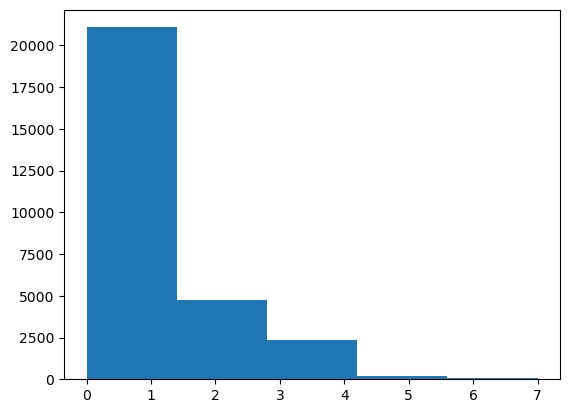

In [28]:
plt.hist(df['bedrooms'], bins=5)

(array([ 2680., 18404.,  4754.,  2381.,   234.]),
 array([0.        , 0.52915026, 1.05830052, 1.58745079, 2.11660105,
        2.64575131]),
 <BarContainer object of 5 artists>)

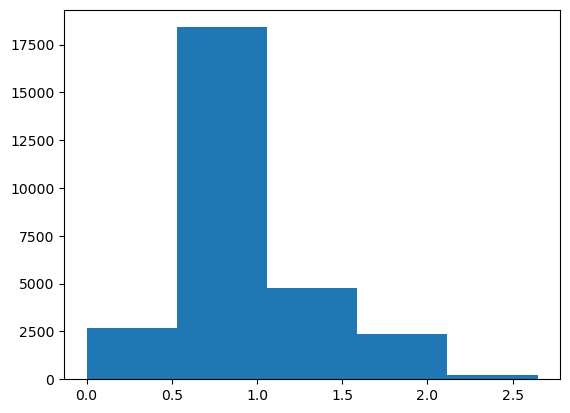

In [29]:
plt.hist(df['bedrooms'].apply(np.sqrt), bins=5)

In [30]:
df['bedrooms']=df['bedrooms'].apply(np.sqrt)

(array([2.3801e+04, 4.0490e+03, 5.7400e+02, 2.4000e+01, 5.0000e+00]),
 array([0. , 1.6, 3.2, 4.8, 6.4, 8. ]),
 <BarContainer object of 5 artists>)

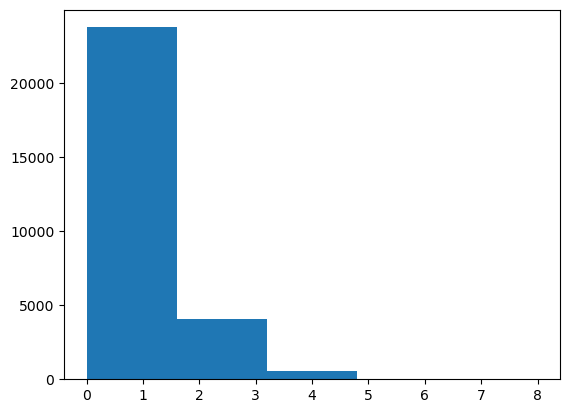

In [31]:
plt.hist(df['bathrooms'], bins=5)

(array([   38.,   226., 23537.,  4594.,    58.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

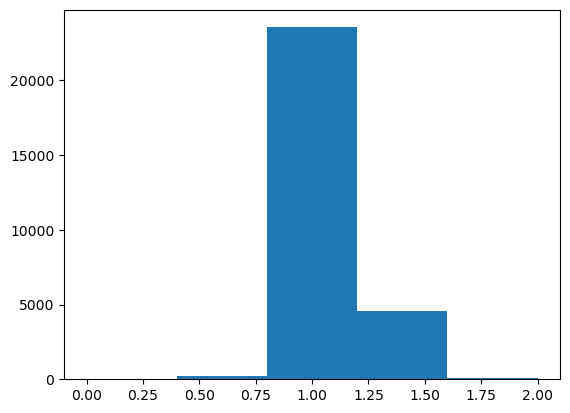

In [32]:
plt.hist(df['bathrooms'].apply(lambda x: pow(x,1/3)), bins=5)

In [33]:
df['bathrooms'] = df['bathrooms'].apply(lambda x: pow(x,1/3))

(array([16953.,  9794.,  1253.,   373.,    80.]),
 array([ 1.,  4.,  7., 10., 13., 16.]),
 <BarContainer object of 5 artists>)

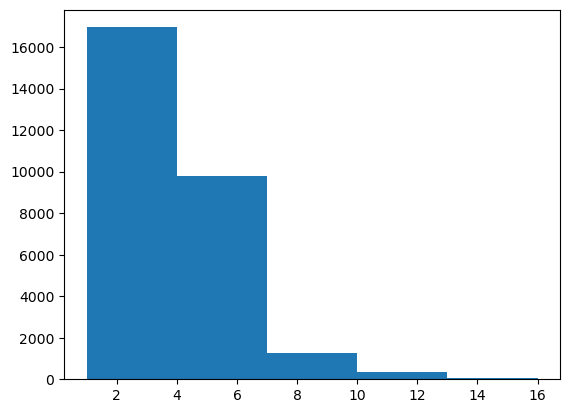

In [34]:
plt.hist(df['accommodates'], bins=5)

(array([ 1786., 15167.,  7163.,  3884.,   453.]),
 array([0.        , 0.240824  , 0.48164799, 0.72247199, 0.96329599,
        1.20411998]),
 <BarContainer object of 5 artists>)

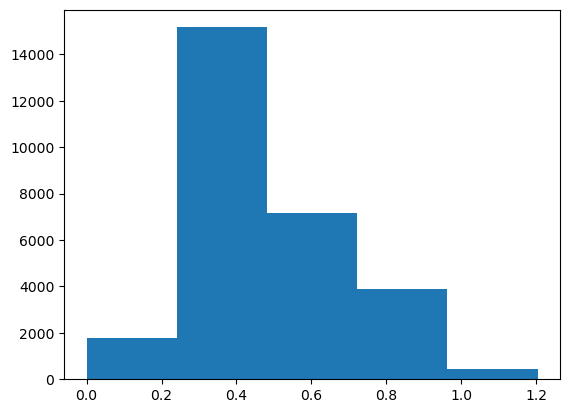

In [35]:
plt.hist(df['accommodates'].apply(np.log10), bins=5)

In [36]:
df['accommodates']=df['accommodates'].apply(np.log10)

(array([2.753e+04, 6.620e+02, 1.990e+02, 2.600e+01, 2.400e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.200e+01]),
 array([  1. ,  23.4,  45.8,  68.2,  90.6, 113. , 135.4, 157.8, 180.2,
        202.6, 225. ]),
 <BarContainer object of 10 artists>)

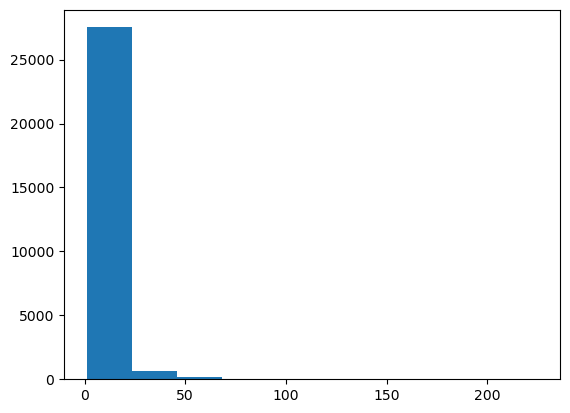

In [37]:
plt.hist(df.beds.apply(lambda x: pow(x,2)), bins =10)

In [38]:
# df.beds = df.beds.apply(lambda x: pow(x,2))

In [39]:
enc = OneHotEncoder(sparse=False)
encode_df = pd.DataFrame(enc.fit_transform(df[['city','zipcode','month']]))
encode_df.columns = enc.get_feature_names(['city','zipcode','month'])

/Users/johnwhendricks/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
df = df.merge(encode_df, left_index=True, right_index=True)
df.drop(columns=['city','zipcode','month'], inplace=True)

In [41]:
df.head()

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,review_scores_rating,price,"city_Ballard, Seattle",city_Phinney Ridge Seattle,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,47.636289,-122.371025,0.60206,1.0,1.0,1.0,95.0,85.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
df.columns

Index(['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'review_scores_rating', 'price', 'city_Ballard, Seattle',
       'city_Phinney Ridge Seattle', 'city_Seattle', 'city_Seattle ',
       'city_West Seattle', 'city_西雅图', 'zipcode_98101', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98104', 'zipcode_98105', 'zipcode_98106',
       'zipcode_98107', 'zipcode_98108', 'zipcode_98109', 'zipcode_98112',
       'zipcode_98115', 'zipcode_98116', 'zipcode_98117', 'zipcode_98118',
       'zipcode_98119', 'zipcode_98121', 'zipcode_98122', 'zipcode_98125',
       'zipcode_98126', 'zipcode_98133', 'zipcode_98134', 'zipcode_98136',
       'zipcode_98144', 'zipcode_98146', 'zipcode_98177', 'zipcode_98178',
       'zipcode_98199', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [47]:
X = df.drop(columns=['price'])
y = df['price']

In [48]:
print(X.shape)
print(y.shape)

(28453, 52)
(28453,)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [51]:
X_train_scaled

array([[ 0.28510236, -1.01041524, -0.69254234, ..., -0.29496652,
        -0.29402689, -0.30167316],
       [ 1.10515403, -0.89162319, -0.69254234, ..., -0.29496652,
        -0.29402689, -0.30167316],
       [ 0.28510236, -1.01041524, -0.69254234, ..., -0.29496652,
        -0.29402689, -0.30167316],
       ...,
       [-1.97251983,  1.0463308 , -1.98121404, ..., -0.29496652,
        -0.29402689, -0.30167316],
       [-0.22504265,  0.35288484,  1.01098899, ..., -0.29496652,
        -0.29402689,  3.31484574],
       [ 0.93935908, -2.18369665,  0.59612937, ..., -0.29496652,
        -0.29402689, -0.30167316]])

In [52]:
y_train

3601     126.000000
25228     95.000000
3600     126.000000
3868     115.000000
4197     104.333333
            ...    
10918     77.225806
22508     60.000000
14691     38.000000
20334    225.000000
24544    350.000000
Name: price, Length: 21339, dtype: float64

In [56]:
X.shape[1]

52

In [57]:
input_dim = X.shape[1]

model = Sequential([
    Dense(200, input_dim = input_dim, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 200)               10600     
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 37,051
Trainable params: 37,051
Non-trainable params: 0
_________________________________________________________________


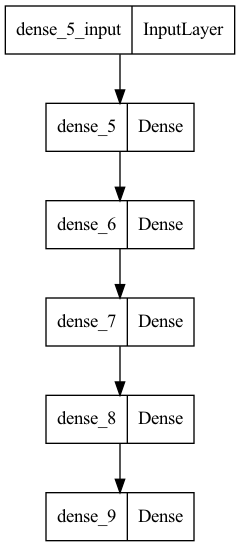

In [58]:
tf.keras.utils.plot_model(model)

In [59]:
model.compile(optimizer='adam',loss='mse')

In [83]:
X_train_scaled.shape

(21339, 52)

In [60]:
history = model.fit(X_train_scaled, y_train, epochs=500, 
                    validation_data=(X_test_scaled, y_test), 
                    callbacks=[
                        tf.keras.callbacks.ModelCheckpoint('model.hdf5', 
                            save_weights_only=True, save_best_only=True)
                    ])

Epoch 1/500
667/667 [==============================] - 2s 2ms/step - loss: 5980.0815 - val_loss: 4213.4487
Epoch 2/500
667/667 [==============================] - 1s 2ms/step - loss: 3771.8274 - val_loss: 4096.5225
Epoch 3/500
667/667 [==============================] - 1s 2ms/step - loss: 3643.0535 - val_loss: 4018.5601
Epoch 4/500
667/667 [==============================] - 1s 1ms/step - loss: 3561.5483 - val_loss: 3915.4326
Epoch 5/500
667/667 [==============================] - 1s 2ms/step - loss: 3499.1765 - val_loss: 4025.2825
Epoch 6/500
667/667 [==============================] - 1s 2ms/step - loss: 3405.2783 - val_loss: 3798.2673
Epoch 7/500
667/667 [==============================] - 1s 1ms/step - loss: 3369.2776 - val_loss: 3725.2617
Epoch 8/500
667/667 [==============================] - 1s 1ms/step - loss: 3272.1638 - val_loss: 3670.4475
Epoch 9/500
667/667 [==============================] - 1s 1ms/step - loss: 3216.7432 - val_loss: 3633.3687
Epoch 10/500
667/667 [===============

667/667 [==============================] - 1s 1ms/step - loss: 741.8762 - val_loss: 1489.8699
Epoch 78/500
667/667 [==============================] - 1s 2ms/step - loss: 706.3400 - val_loss: 1246.4352
Epoch 79/500
667/667 [==============================] - 1s 2ms/step - loss: 745.2463 - val_loss: 1421.0435
Epoch 80/500
667/667 [==============================] - 1s 1ms/step - loss: 731.0861 - val_loss: 1372.1577
Epoch 81/500
667/667 [==============================] - 1s 2ms/step - loss: 690.7922 - val_loss: 1369.0504
Epoch 82/500
667/667 [==============================] - 1s 2ms/step - loss: 657.8653 - val_loss: 1293.2368
Epoch 83/500
667/667 [==============================] - 1s 2ms/step - loss: 685.8965 - val_loss: 1594.7905
Epoch 84/500
667/667 [==============================] - 1s 1ms/step - loss: 735.7105 - val_loss: 1363.9955
Epoch 85/500
667/667 [==============================] - 1s 2ms/step - loss: 625.2625 - val_loss: 1286.1528
Epoch 86/500
667/667 [============================

667/667 [==============================] - 1s 1ms/step - loss: 371.7719 - val_loss: 956.8699
Epoch 154/500
667/667 [==============================] - 1s 1ms/step - loss: 366.6334 - val_loss: 965.9755
Epoch 155/500
667/667 [==============================] - 1s 1ms/step - loss: 355.2944 - val_loss: 998.5135
Epoch 156/500
667/667 [==============================] - 1s 1ms/step - loss: 363.9151 - val_loss: 1087.7959
Epoch 157/500
667/667 [==============================] - 1s 1ms/step - loss: 371.2469 - val_loss: 864.8326
Epoch 158/500
667/667 [==============================] - 1s 1ms/step - loss: 365.0140 - val_loss: 1041.6637
Epoch 159/500
667/667 [==============================] - 1s 1ms/step - loss: 379.2403 - val_loss: 983.2580
Epoch 160/500
667/667 [==============================] - 1s 1ms/step - loss: 339.2318 - val_loss: 975.6191
Epoch 161/500
667/667 [==============================] - 1s 1ms/step - loss: 356.6006 - val_loss: 1102.2906
Epoch 162/500
667/667 [=========================

667/667 [==============================] - 1s 1ms/step - loss: 283.2189 - val_loss: 815.4505
Epoch 230/500
667/667 [==============================] - 1s 2ms/step - loss: 219.4479 - val_loss: 826.7662
Epoch 231/500
667/667 [==============================] - 1s 2ms/step - loss: 230.6527 - val_loss: 825.1906
Epoch 232/500
667/667 [==============================] - 1s 2ms/step - loss: 227.9193 - val_loss: 904.2441
Epoch 233/500
667/667 [==============================] - 1s 2ms/step - loss: 288.3175 - val_loss: 788.8771
Epoch 234/500
667/667 [==============================] - 1s 1ms/step - loss: 295.7317 - val_loss: 857.5192
Epoch 235/500
667/667 [==============================] - 1s 1ms/step - loss: 251.4040 - val_loss: 946.2325
Epoch 236/500
667/667 [==============================] - 1s 2ms/step - loss: 250.7041 - val_loss: 718.8038
Epoch 237/500
667/667 [==============================] - 1s 1ms/step - loss: 229.9993 - val_loss: 908.2328
Epoch 238/500
667/667 [============================

667/667 [==============================] - 1s 2ms/step - loss: 185.6496 - val_loss: 804.0059
Epoch 306/500
667/667 [==============================] - 1s 2ms/step - loss: 170.1530 - val_loss: 699.5254
Epoch 307/500
667/667 [==============================] - 1s 2ms/step - loss: 182.8398 - val_loss: 836.8547
Epoch 308/500
667/667 [==============================] - 1s 2ms/step - loss: 188.1755 - val_loss: 673.9338
Epoch 309/500
667/667 [==============================] - 1s 1ms/step - loss: 196.7278 - val_loss: 794.2160
Epoch 310/500
667/667 [==============================] - 1s 1ms/step - loss: 172.6362 - val_loss: 691.5375
Epoch 311/500
667/667 [==============================] - 1s 1ms/step - loss: 182.2324 - val_loss: 793.0282
Epoch 312/500
667/667 [==============================] - 1s 2ms/step - loss: 167.1570 - val_loss: 646.6341
Epoch 313/500
667/667 [==============================] - 2s 3ms/step - loss: 181.5831 - val_loss: 851.5078
Epoch 314/500
667/667 [============================

667/667 [==============================] - 1s 1ms/step - loss: 142.1178 - val_loss: 753.2834
Epoch 382/500
667/667 [==============================] - 1s 1ms/step - loss: 142.3718 - val_loss: 802.9575
Epoch 383/500
667/667 [==============================] - 1s 1ms/step - loss: 166.6582 - val_loss: 821.7158
Epoch 384/500
667/667 [==============================] - 1s 2ms/step - loss: 149.0409 - val_loss: 717.4296
Epoch 385/500
667/667 [==============================] - 1s 2ms/step - loss: 136.7433 - val_loss: 793.2773
Epoch 386/500
667/667 [==============================] - 1s 1ms/step - loss: 150.3835 - val_loss: 722.5479
Epoch 387/500
667/667 [==============================] - 1s 1ms/step - loss: 128.8614 - val_loss: 898.5826
Epoch 388/500
667/667 [==============================] - 1s 2ms/step - loss: 153.0191 - val_loss: 693.1303
Epoch 389/500
667/667 [==============================] - 1s 2ms/step - loss: 139.6230 - val_loss: 770.1555
Epoch 390/500
667/667 [============================

667/667 [==============================] - 1s 1ms/step - loss: 106.0472 - val_loss: 697.7503
Epoch 458/500
667/667 [==============================] - 1s 1ms/step - loss: 112.4205 - val_loss: 750.9907
Epoch 459/500
667/667 [==============================] - 1s 1ms/step - loss: 115.1497 - val_loss: 698.5190
Epoch 460/500
667/667 [==============================] - 1s 1ms/step - loss: 125.1368 - val_loss: 730.9598
Epoch 461/500
667/667 [==============================] - 1s 1ms/step - loss: 119.6940 - val_loss: 741.8545
Epoch 462/500
667/667 [==============================] - 1s 1ms/step - loss: 119.1528 - val_loss: 660.7217
Epoch 463/500
667/667 [==============================] - 1s 2ms/step - loss: 128.4255 - val_loss: 735.0774
Epoch 464/500
667/667 [==============================] - 1s 1ms/step - loss: 120.2309 - val_loss: 733.3544
Epoch 465/500
667/667 [==============================] - 1s 2ms/step - loss: 112.5696 - val_loss: 728.9304
Epoch 466/500
667/667 [============================

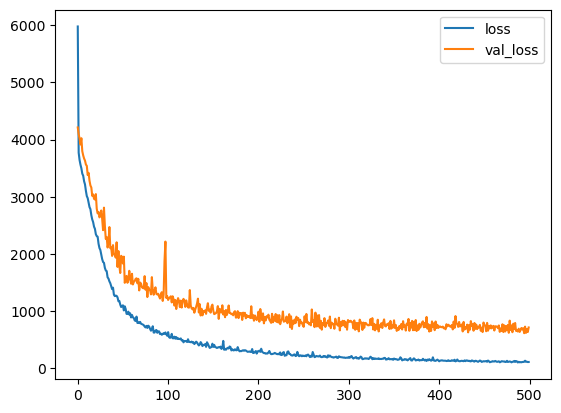

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [66]:
model.load_weights('model.hdf5')
y_pred = model.predict(X_test_scaled)

223/223 [==============================] - 0s 959us/step


Text(0.5, 0, 'predicted price')

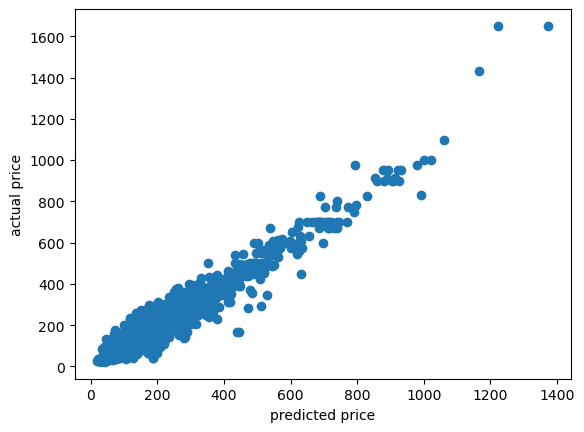

In [67]:
plt.scatter(y_pred, y_test)
plt.ylabel('actual price')
plt.xlabel('predicted price')

In [68]:
y_pred.tolist()

[[265.8288269042969],
 [90.84444427490234],
 [104.6323471069336],
 [200.6581268310547],
 [244.0178985595703],
 [134.79673767089844],
 [129.973388671875],
 [86.65369415283203],
 [79.5465316772461],
 [67.89588928222656],
 [210.3629608154297],
 [71.38021087646484],
 [100.00261688232422],
 [434.669921875],
 [142.45413208007812],
 [112.43846130371094],
 [101.77379608154297],
 [319.1298828125],
 [111.78134155273438],
 [631.758544921875],
 [53.78691101074219],
 [180.91307067871094],
 [385.4140625],
 [113.35000610351562],
 [96.56285858154297],
 [75.86546325683594],
 [218.4283905029297],
 [59.57274627685547],
 [101.25727844238281],
 [106.56446838378906],
 [34.958072662353516],
 [277.0972900390625],
 [87.08150482177734],
 [98.75020599365234],
 [181.2866668701172],
 [66.87850952148438],
 [90.33734893798828],
 [858.09130859375],
 [56.99446105957031],
 [147.83990478515625],
 [128.9357147216797],
 [77.7103042602539],
 [113.70496368408203],
 [128.6588897705078],
 [119.68755340576172],
 [64.3155441284

In [69]:
y_test.values.tolist()

[340.0,
 85.0,
 136.5,
 195.0,
 250.0,
 128.2258064516129,
 120.0,
 82.75862068965517,
 80.0,
 69.0,
 190.06451612903226,
 65.0,
 97.75862068965517,
 424.3666666666667,
 135.0,
 97.0,
 104.0,
 341.0,
 95.0,
 610.0,
 55.0,
 163.79310344827587,
 290.0,
 115.0,
 94.33333333333333,
 75.0,
 250.0,
 60.0,
 97.74193548387096,
 106.73076923076923,
 30.0,
 207.74193548387098,
 85.0,
 115.0,
 199.0,
 65.0,
 131.6,
 900.0,
 60.0,
 139.13793103448276,
 150.0,
 67.58064516129032,
 115.0,
 107.25806451612904,
 97.3076923076923,
 60.0,
 600.0,
 165.0,
 230.0,
 25.0,
 71.66666666666667,
 110.0,
 70.11111111111111,
 228.33333333333334,
 109.0,
 55.0,
 135.0,
 65.0,
 65.0,
 82.0,
 43.0,
 88.61290322580645,
 114.77777777777777,
 65.0,
 103.14814814814815,
 85.0,
 65.0,
 79.51612903225806,
 63.0,
 90.0,
 98.0,
 168.0,
 75.16129032258064,
 79.0,
 250.0,
 200.0,
 119.19354838709677,
 103.38709677419355,
 250.0,
 97.0,
 128.66666666666666,
 111.5,
 70.0,
 72.0,
 395.0,
 125.80645161290323,
 79.0,
 250.0,
 74

In [70]:
results_df = pd.DataFrame({'predicted price':y_pred[:,0]})
results_df.head()

,predicted price
0,265.828827
1,90.844444
2,104.632347
3,200.658127
4,244.017899


In [71]:
results_df['actual price'] = y_test.values

In [72]:
results_df.head(20)

,predicted price,actual price
0,265.828827,340.000000
1,90.844444,85.000000
2,104.632347,136.500000
3,200.658127,195.000000
4,244.017899,250.000000
5,134.796738,128.225806
6,129.973389,120.000000
7,86.653694,82.758621
8,79.546532,80.000000
9,67.895889,69.000000


In [73]:
results_df['diff'] = abs(results_df['predicted price'] - results_df['actual price'])
results_df

,predicted price,actual price,diff
0,265.828827,340.000000,74.171173
1,90.844444,85.000000,5.844444
2,104.632347,136.500000,31.867653
3,200.658127,195.000000,5.658127
4,244.017899,250.000000,5.982101
...,...,...,...
7109,83.535461,75.000000,8.535461
7110,121.049156,153.666667,32.617510
7111,82.064201,95.000000,12.935799
7112,158.358841,159.000000,0.641159


In [74]:
rmse = np.sqrt(history.history['val_loss'][-1])
diffs = results_df['diff'].sum() / results_df.shape[0]
results_df['lower'] = round(results_df['predicted price'] - 2*rmse)
results_df['upper'] = round(results_df['predicted price'] + 2*rmse)

results_df.loc[results_df['lower'] < 20, 'lower'] = 20

results_df['accurate'] = (results_df['lower'] <= results_df['actual price']) & (results_df['actual price'] <= results_df['upper']) 
results_df.tail()

,predicted price,actual price,diff,lower,upper,accurate
7109,83.535461,75.000000,8.535461,30.0,137.0,True
7110,121.049156,153.666667,32.617510,68.0,174.0,True
7111,82.064201,95.000000,12.935799,29.0,136.0,True
7112,158.358841,159.000000,0.641159,105.0,212.0,True
7113,103.136818,90.000000,13.136818,50.0,157.0,True


In [75]:
results_df.head(20)

,predicted price,actual price,diff,lower,upper,accurate
0,265.828827,340.000000,74.171173,212.0,319.0,False
1,90.844444,85.000000,5.844444,37.0,144.0,True
2,104.632347,136.500000,31.867653,51.0,158.0,True
3,200.658127,195.000000,5.658127,147.0,254.0,True
4,244.017899,250.000000,5.982101,191.0,297.0,True
5,134.796738,128.225806,6.570931,81.0,188.0,True
6,129.973389,120.000000,9.973389,77.0,183.0,True
7,86.653694,82.758621,3.895073,33.0,140.0,True
8,79.546532,80.000000,0.453468,26.0,133.0,True
9,67.895889,69.000000,1.104111,20.0,121.0,True


In [76]:
results_df[results_df['accurate'] == False]

,predicted price,actual price,diff,lower,upper,accurate
0,265.828827,340.000000,74.171173,212.0,319.0,False
22,385.414062,290.000000,95.414062,332.0,439.0,False
31,277.097290,207.741935,69.355355,224.0,331.0,False
47,437.830841,165.000000,272.830841,384.0,491.0,False
48,305.438171,230.000000,75.438171,252.0,359.0,False
...,...,...,...,...,...,...
7000,279.819489,214.354839,65.464650,226.0,333.0,False
7020,282.590485,338.333333,55.742849,229.0,336.0,False
7057,282.328430,347.193548,64.865118,229.0,336.0,False
7095,99.886475,159.000000,59.113525,46.0,153.0,False


In [77]:
results_df['accurate'].value_counts()

True     6813
False     301
Name: accurate, dtype: int64

In [78]:
results_df['accurate'].value_counts()[1] / results_df['accurate'].value_counts().sum()

0.957689063817824

In [79]:
_, _, r_value, _, _ = linregress(results_df['predicted price'].values,results_df['actual price'].values)

In [80]:
print('r value:',r_value)

r value: 0.9736336514428118


In [87]:
pickle.dump(model, open('model.sav','wb'))

INFO:tensorflow:Assets written to: ram://96dfb478-3c2a-465a-8c44-5918a140dbae/assets


In [91]:
type(pickle.load(open('model.sav','rb')).load_weights('model.hdf5'))

NoneType

In [82]:
pickle.dump(rmse, open('rmse.sav','wb'))

In [92]:
model.save_weights('weights.h5')

AttributeError: 'History' object has no attribute 'weights'